**Experimenting With Frequencies**:

**1) Run the Example:** run the cell below to see the output of the fourier magnitude and the images.

**2) Create Composite Images:** create your own image with a combination of different sinosoidal frequencies and orientations.

**3) Separate Frequencies:** Remove certain frequencies from the image. This is done in the frequency domain. Use a circular mask image to block the higher frequencies in Fourier space. Then subtract two masks to create a circular band pass mask that blocks both higher and lower frequencies in Fourier space.

**4) Match Gaussian Blur:** Use the mask filter with various radii on the Einstein image. What happens to the image as the mask circle becomes smaller? How is this different from applying a Gaussian blur filter to the image? Try to match the mask filter output to the Gaussian blur images.

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import cv2

from scipy.ndimage import convolve
from scipy import signal

from PIL import Image
import urllib

In [ ]:
# Useful Functions

# Create sin images of a specific frequency and orientation
def create_sin_grating(f, theta):

  # size of the image
  x = np.arange(-128, 129, 1)
  X, Y = np.meshgrid(x, x)

  return np.sin( np.pi * f * ( X * np.cos(theta) + Y * np.sin(theta) ) )

# Display the fft and the image
def display_fft(in_img, title, log=False, fixed_range=False):

  # fourier image
  [ydim, xdim] = in_img.shape
  win = np.outer(np.hanning(ydim), np.hanning(xdim))
  win = win/np.mean(win)

  # fourier image
  F = np.fft.fftshift(np.fft.fft2(in_img*win))
  Fmag = np.abs(F)
  Fmag[Fmag < 0.01] = 0.01

  # Display results
  fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 5))

  # Display image
  if fixed_range:
    axes[0].imshow(in_img, vmin=0, vmax=1, cmap=plt.cm.gray)
  else:
    axes[0].imshow(in_img, cmap=plt.cm.gray)
  axes[0].set_axis_off()
  axes[0].set_title('Input Image')

  if log:
    axes[1].imshow(np.log(Fmag), cmap=plt.cm.gray)
  else:
    axes[1].imshow(Fmag, cmap=plt.cm.gray)
  axes[1].set_axis_off()
  axes[1].set_title('Fourier Magnitude')

  plt.suptitle(f'{title}')
  plt.show()

# Create a radial mask
def create_mask(in_rad, shape):

  # create circle mask
  in_mask = np.zeros(shape)
  cy = in_mask.shape[0] // 2
  cx = in_mask.shape[1] // 2
  cv2.circle(in_mask, (cx,cy), in_rad, (255, 255, 255), -1)[0]
  in_mask = in_mask / 255

  # blur the mask
  mask2 = cv2.GaussianBlur(in_mask, (15, 15), 10.5, cv2.BORDER_DEFAULT)

  return mask2

# Apply a mask to the FFT image
def mask_fft(in_img, mask):

  F = np.fft.fftshift(np.fft.fft2(in_img))
  Fmag = np.abs(F) * mask

  # the ifft assume the incoming fft is shifted to the center of the image
  combined = np.fft.ifftshift(np.multiply(Fmag, np.exp(1j * np.angle(F))))
  imgCombined = np.real(np.fft.ifft2(combined))

  return imgCombined

# Create a Gaussian of a specific size
def create_2d_gaussian(size=9, std=1.5):

    gaussian_1d = signal.gaussian(size, std=std)
    gaussian_2d = np.outer(gaussian_1d, gaussian_1d)
    gaussian_2d = gaussian_2d / (gaussian_2d.sum())

    return gaussian_2d

def read_img(url):
  return np.array(Image.open(urllib.request.urlopen(url)))

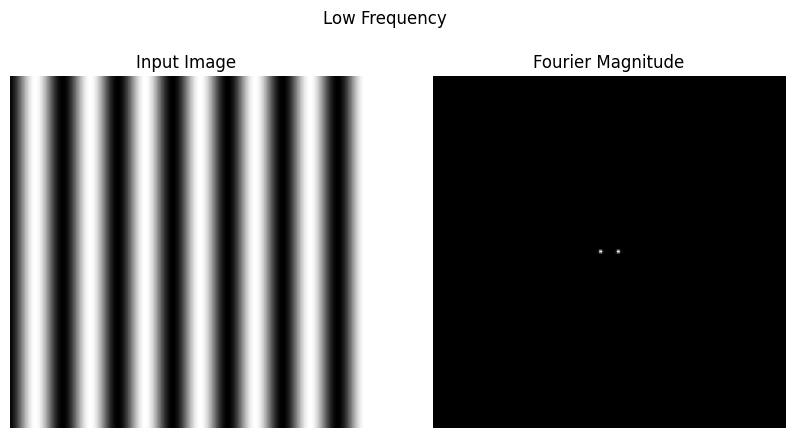

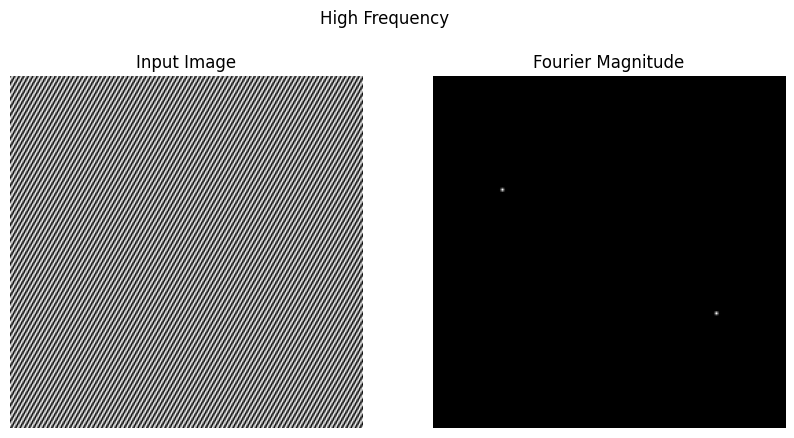

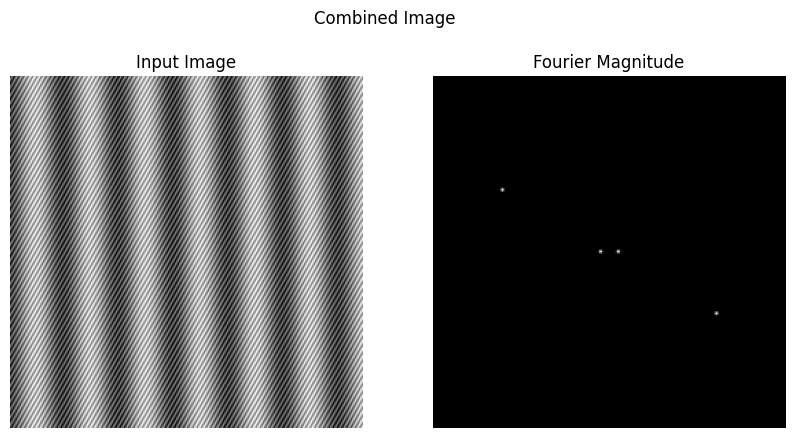

In [ ]:
# Part 1: Run this cell to see how the code works

# first argument is frequency
# second argument is orientation

# low frequency image
img1 = create_sin_grating(0.05, (0 * np.pi) / 180)
display_fft(img1, 'Low Frequency')

# high frequency image
img2 = create_sin_grating(0.7, (30 * np.pi) / 180)
display_fft(img2, 'High Frequency')

# mix
img3 = img1 + img2
display_fft(img3, 'Combined Image')

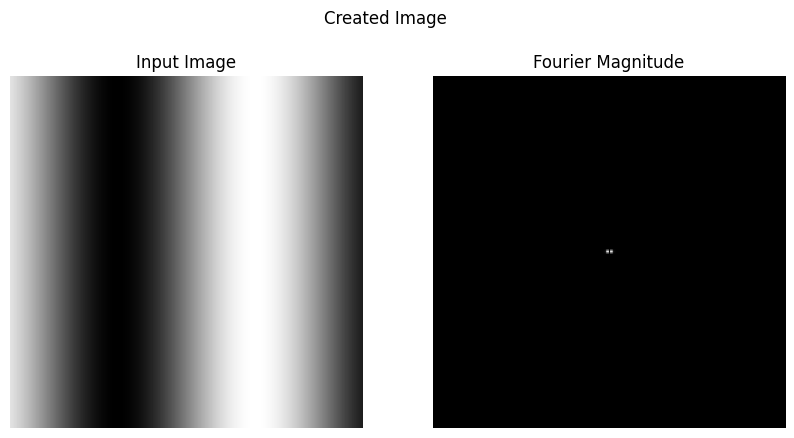

In [ ]:
# Part 2: Create your own image to create the 2D image patterns:


# TODO: fill in a combination of freq and angle

freq = 0.01
angle = 0


img_create = np.zeros((257, 257))
img_create = create_sin_grating(freq, (angle * np.pi) / 180)

display_fft(img_create, 'Created Image')

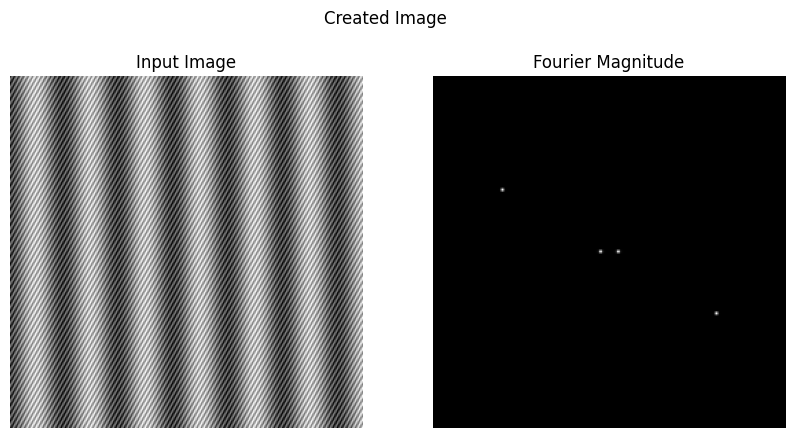

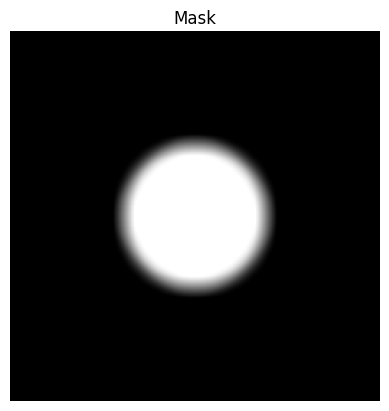

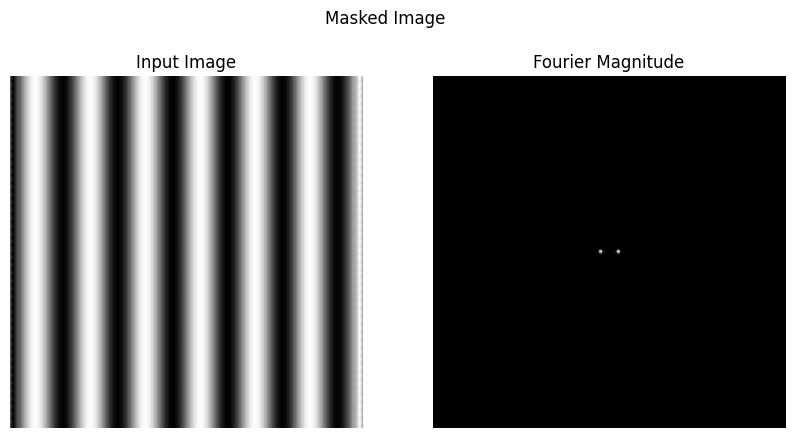

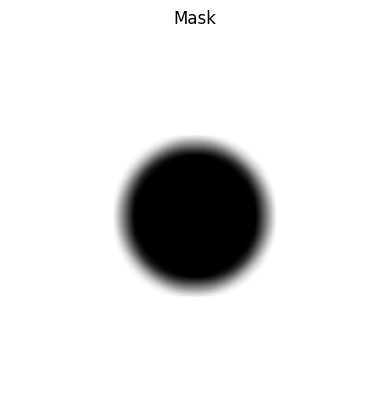

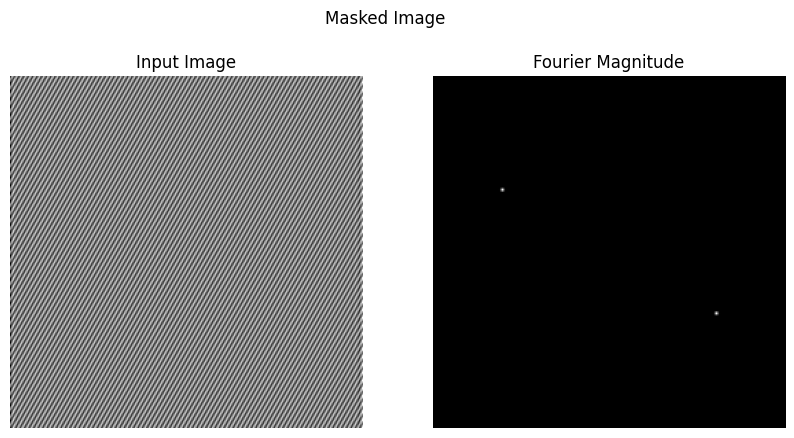

In [ ]:
# Part 3: Separate out specific frequencies
freqs = [0.05, 0.7]
angles = [0, 30]

im3 = np.zeros((257, 257))
for i in range(len(freqs)):
  im3 = im3 + create_sin_grating(freqs[i], (angles[i] * np.pi) / 180)

img3 = img3 / len(freqs)
display_fft(img3, 'Created Image')

# TODO: Change the radius of the mask so that the output image has
# only the low frequency sinosoid (low pass filter)

# create a mask which is 1 in the center portion
# with a radius defined in pixels
mask = create_mask(50, img3.shape)
plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

# apply the mask to the fft of the image
masked_image = mask_fft(img3, mask)
display_fft(masked_image, 'Masked Image')

# TODO: Change the mask so that the output image after masking the FFT of the image has
# only the high frequency sinosoid (high pass filter)
mask = 1 - mask

plt.imshow(mask, cmap='gray')
plt.axis('off')
plt.title('Mask')
plt.show()

masked_image = mask_fft(img3, mask)
display_fft(masked_image, 'Masked Image')

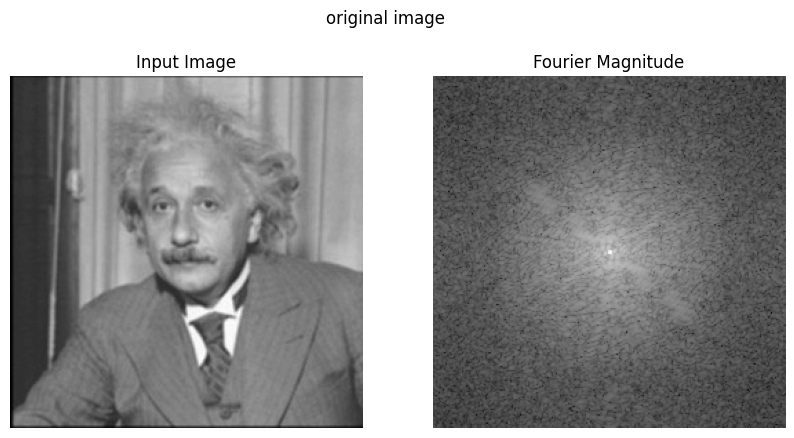

**************************************************************************







<ipython-input-3-4d50e2f96c36>:76: DeprecationWarning: Importing gaussian from 'scipy.signal' is deprecated and will raise an error in SciPy 1.13.0. Please use 'scipy.signal.windows.gaussian' or the convenience function 'scipy.signal.get_window' instead.
  gaussian_1d = signal.gaussian(size, std=std)


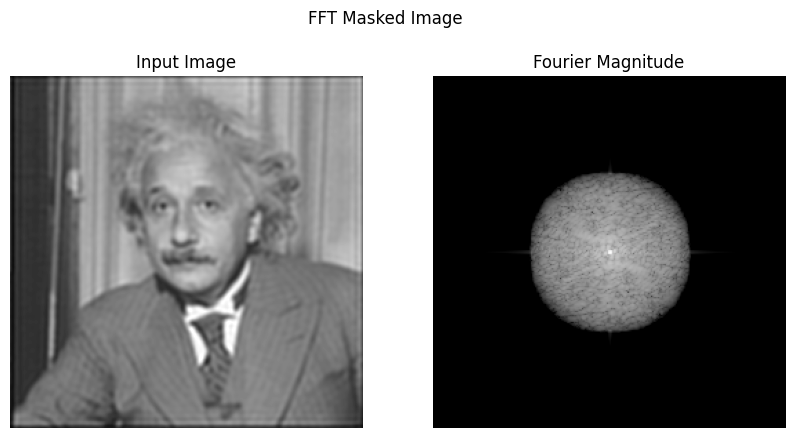

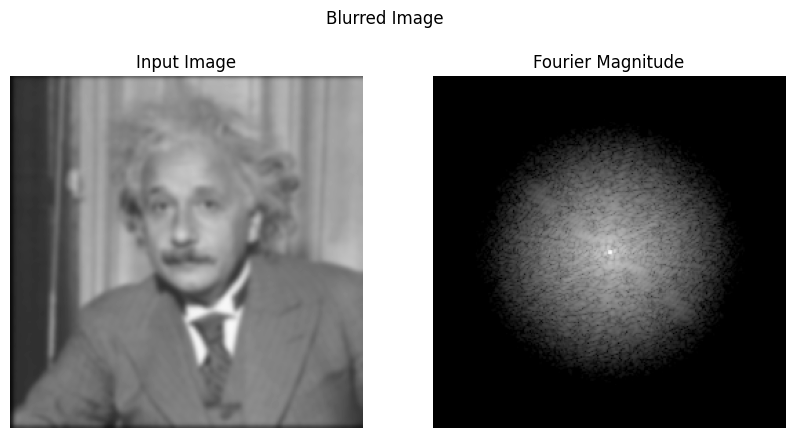

**************************************************************************







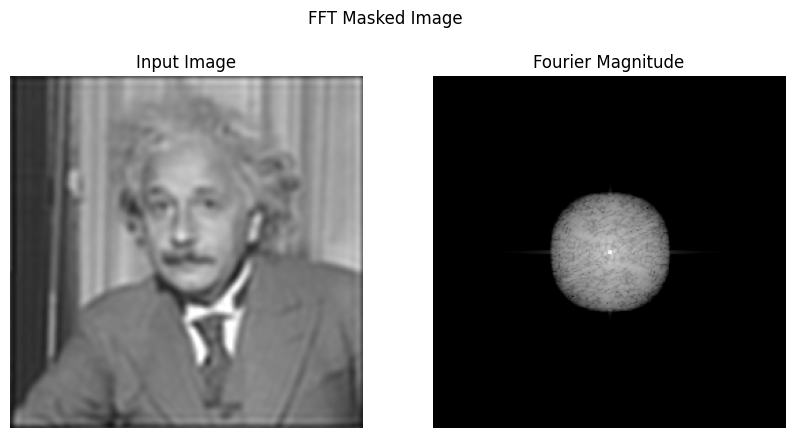

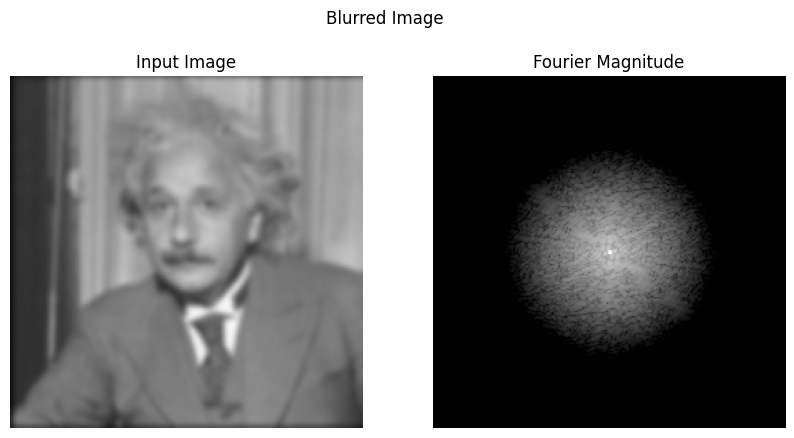

**************************************************************************







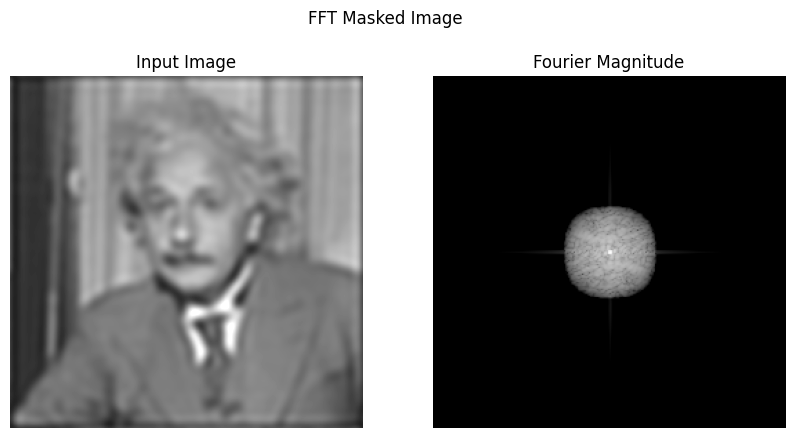

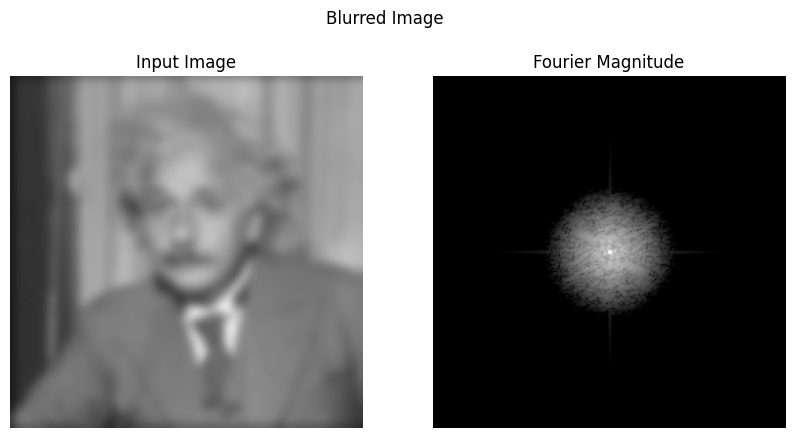

In [ ]:
# Part 4: Match Gaussian Blur

# Load Einstein image and convert to double
al_img = 1.0 * read_img("https://raw.githubusercontent.com/W281/fileRepository/main/convolution/al.png")
al_img = al_img[:, :, 0]
if np.max(al_img) > 1:
    al_img = al_img / 255.0

display_fft(al_img, 'original image', log=True)

# set Gaussian sigmas and sizes
sigma = [1.5, 2, 3.5]
gsize = [17, 23, 35]

# TODO: Set appropriate FFT mask sizes to match the Gaussian Filters above
ms = [50, 35, 25]

for i in range(len(ms)):

  print('**************************************************************************\n\n\n\n\n')

  # apply mask to FFT of original image
  mask  = create_mask(ms[i], al_img.shape)
  fft_masked_image = mask_fft(al_img, mask)

  # apply blur to original image
  gauss = create_2d_gaussian(size=gsize[i], std=sigma[i])
  blur_img = convolve(al_img, gauss, mode='reflect')

  # compare resulting images and FFTs
  display_fft(fft_masked_image, 'FFT Masked Image', log=True, fixed_range=True)
  display_fft(blur_img, 'Blurred Image', log=True, fixed_range=True)